In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# 7. PyMC3による（ベイズ）線形回帰
確率的モデリング用ライブラリとして有名な**PyMC3**を利用して線形回帰を行ってみる<br>
## 7-1. ライブラリのダウンロード！！
```
pip install pymc3
```
もしうまくいかない場合はpythonのバージョンが問題である可能性があるため，仮想環境を作成するなどしてバージョンをPython3.8にするとうまくいく可能性がある．<br>
PYMC3に関する仮想環境の作り方は，[この記事](https://qiita.com/shinji_komine/items/241bf073970abac733c4)が参考になるかもしれない．


In [2]:
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


## 7-2. データセットをダウンロード&データの準備

In [3]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
! mv winequality-red.csv data/winequality-red.csv

--2021-09-29 11:57:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84199 (82K) [application/x-httpd-php]
`winequality-red.csv' に保存中

100%[======================================>] 84,199       368KB/s 時間 0.2s     

2021-09-29 11:57:02 (368 KB/s) - `winequality-red.csv' へ保存完了 [84199/84199]



In [3]:
wine = pd.read_csv("./data/winequality-red.csv", sep=";") # sepは区切り文字の指定
display(wine.head(5))
np.random.seed(0) # random　の挙動を固定

X = wine[["density"]].values
T = wine["alcohol"].values
X = X - X.mean()
T = T - T.mean()

#X, Tそれぞれが最小値0, 最大値1になるように標準化
#追加の前処理部分
X = (X - X.min()) / (X.max() - X.min())
T = (T - T.min()) / (T.max() - T.min())

p = np.random.permutation(len(X))
X = X[p]
T = T[p]

X_train = X[:1000, :]
T_train = T[:1000]
X_test = X[1000:, :]
T_test = T[1000:]

data = dict(x=X_train, y=T_train)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


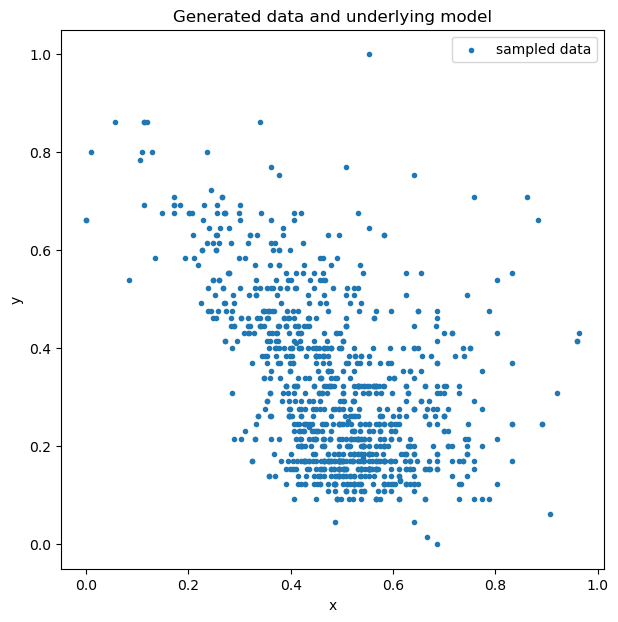

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.scatter(X_train, T_train, marker=".", label="sampled data")
plt.legend(loc=0);

## 7-3. モデル構築から事後分布導出まで
pytorchではどんなlossを使用するのか，いつ学習を行うのか，データはいくつに分割するのか，などを一つ一つ丁寧に定義していきました．<br>
しかしながら尤度最大化を最終目的とする確率モデリングでは（基本的に）それぞれのパラメータが従う分布さえ与えてやれば損失関数などは与える必要がありません．<br>
事前知識や既知の事実をパラメータとして与えることができる上に記述が簡素で読みやすいのがPyMC3の特徴です．**ただし計算量は大きい**<br><br>
以下では先ほどのwineデータに対して
$$
\begin{eqnarray}
p({\bf t|w}) &=& \prod_{n=1}^N{\mathcal N}(t_n|{\bf w^{\rm T}x}, \lambda)\\
p({\bf w}) &=& {\mathcal N}({\bf w|0}, {\bf 1})\\
p(\lambda) &=& {\rm Gamma}(\lambda|mu=1, sigma=0,2)
\end{eqnarray}
$$
と言う分布を仮定して回帰を行ってみます．<br>
データに対してフィットするように事後分布を求めるのが目標ですが，こちらも**基本的に解析的に求めれない**ことを仮定しているので**MCMC**とよばれる手法を使用して事後分布を求めています．これについてはまだ先で学ぶことだと思うので，今は**非解析的に事後分布を求める手法**とざっくり考えておいてもらっても良いかと思います．
<br>（ガンマ分布のパラメータとして今回は平均，分散を与えました．もちろん$\alpha, \beta$での初期化も可能です．）

In [5]:
inf = 10000


with pm.Model() as model:#以下のコードブロック中でそれぞれの分布を定義する
    
    #このコードブロック内で定義されたパラメータが順にモデルに追加されていく
    
    #https://docs.pymc.io/api/distributions/continuous.html
    #他にも色々な分布形が用意されている
    
    #各パラメータの分布定義
    sigma = pm.Gamma("sigma", mu=1, sigma=0.2)#データの分散に対する事前分布
    intercept = pm.Normal("Intercept", 0, sigma=1)#切片に対する事前分布
    x_coeff = pm.Normal("x_coeff", 0, sigma=1)#係数に関する事前分布
    
    #観測値
    x = pm.Data("x", X_train.reshape(-1))
    t = pm.Data("t", T_train.reshape(-1))
    
    
    #尤度定義
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=t)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8922936980077784, but should be close to 0.8. Try to increase the number of tuning steps.


## 7-4. パラメータ事後分布の可視化
では実際に推論の結果求まった事後分布を可視化してみる．まずは各パラメータの事後分布から．<br>
左には導出されたパラメータの分布が表示される．（点線は本来捨てられる初期の探索を含んだもの．一旦無視して良い．**筈．間違ってたら教えて欲しい**）<br>
右にはMCMCでの探索の経路が表示される．（こちらも一旦無視して良い）

<Figure size 700x700 with 0 Axes>

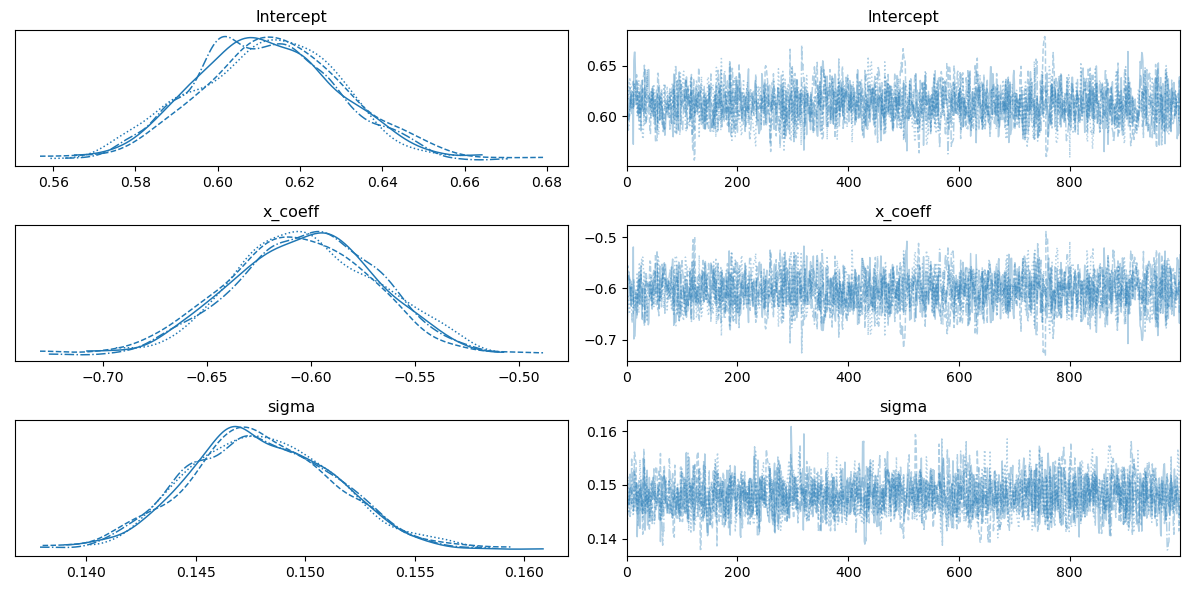

In [6]:
plt.figure(figsize=(7, 7))
pm.traceplot(idata)
plt.tight_layout();

与えた事前分布が変化しているのを確認して欲しい．<br>
次に各入力に対する予測分布も可視化してみる

In [7]:
lin_x = np.linspace(0, 1, 11)
with model:
    pm.set_data(
        {
            "x": lin_x,#新たな入力値
            "t": np.zeros_like(lin_x),#ダミーで目標値をおいておく必要がある（なんでもいい）数値を変えても結果が変わらないことを確認するのも良い
        }
    )
    post_pred = pm.sample_posterior_predictive(idata.posterior)

x: 0.1, mu: 0.5488109627791753, var: 0.022160719952863492
x: 0.30000000000000004, mu: 0.43026721426442843, var: 0.02257232300016856
x: 0.5, mu: 0.3094575017298507, var: 0.022804199449339067
x: 0.7000000000000001, mu: 0.18813709145056848, var: 0.021713700156241956
x: 0.9, mu: 0.07220215498990319, var: 0.021773932840804384


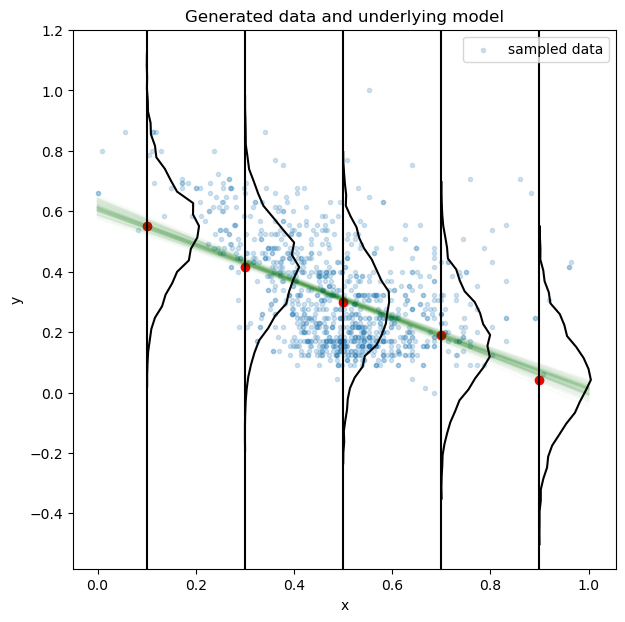

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")


#学習，推論に用いたデータの描写
ax.scatter(X_train, T_train, marker=".", label="sampled data", alpha=0.2)

#予測線の描写
#事後分布（MCMCの探索履歴）から切片と傾きをランダムにサンプリングして100個表示する
for _ in range(100):
    chain = np.random.randint(0, 3)
    draw = np.random.randint(0, 999)
    coeff = float(idata.posterior.x_coeff[chain][draw])
    inter = float(idata.posterior.Intercept[chain][draw])
    ax.plot(lin_x, lin_x*coeff+inter, c='g', alpha=0.02)

#各入力値における確率分布の描写
#今回の例では原理的にどんな入力に対しても同じ種類，　同じ分散の分布になる（平均は違う）
for i in range(1, 11, 2):
    #print(len(post_pred['y'][:, i]))
    dist = np.array(np.histogram(post_pred['y'][:, i], bins=30))
    mu, var = np.average(post_pred['y'][:, i]), np.var(post_pred['y'][:, i])
    print(f'x: {lin_x[i]}, mu: {mu}, var: {var}')
    dist[0] = dist[0] / len(post_pred['y'][:, i]) + lin_x[i]
    ax.plot(dist[0], dist[1][:-1], c = 'black')
    ind = np.argmax(dist[0])
    ax.scatter(lin_x[i], dist[1][ind], c = 'red')
    ax.axvline(x=lin_x[i], c = 'black')

plt.legend(loc=0)

In [9]:
#パラメータの事後分布がどんな形かを確認
inters = np.array(idata.posterior.Intercept).reshape(-1)
coeffs = np.array(idata.posterior.x_coeff).reshape(-1)
print(f'intercept distribution: mu = {np.mean(inters)}, var = {np.var(inters)}')
print(f'x-coeff distribution  : mu = {np.mean(coeffs)}, var = {np.var(coeffs)}')

intercept distribution: mu = 0.6120920670378238, var = 0.00030361691859368965
x-coeff distribution  : mu = -0.6035843170769482, var = 0.0011830278828384691
